In [2]:
import pandas as pd
import numpy as np
import os
import mxnet as mx
import shutil

In [3]:
data_dir = "/Users/shengwan/Desktop/data"
train_dir = "train"
test_dir = "test"
train_gy_dir = "train_gy"
test_gy_dir = "test_gy"

## Preprocess

In [5]:
# remove original directory
train_gy_path = os.path.join(data_dir, train_gy_dir)
if os.path.exists(train_gy_path):
    shutil.rmtree(train_gy_path)
    
# make new directory
if not os.path.exists(train_gy_path):
    os.makedirs(train_gy_path)
    
# get training data id and labels
id_labels = pd.read_csv(os.path.join(data_dir, "labels.csv"))

# construct sym link between train_dir and train_gy_dir
for _, (curr_id, curr_breed) in id_labels.iterrows():
    dst_dir = os.path.join(train_gy_path, curr_breed)
    if not os.path.exists(dst_dir):
        os.makedirs(dst_dir)
    src_loc = os.path.join(data_dir, train_dir, curr_id+".jpg")
    dst_loc = os.path.join(dst_dir, curr_id+".jpg")
    os.symlink(src_loc, dst_loc)

In [6]:
# remove original directory
test_gy_path = os.path.join(data_dir, test_gy_dir)
if os.path.exists(test_gy_path):
    shutil.rmtree(test_gy_path)
    
# make new directory
if not os.path.exists(test_gy_path):
    os.makedirs(test_gy_path)

# construct sym link between test_dir and test_gy_dir
for roor_dir, sub_dir, sub_files in os.walk(os.path.join(data_dir, test_dir)):
    for sub_file in sub_files:
        dst_dir = os.path.join(test_gy_path, "0")
        if not os.path.exists(dst_dir):
            os.makedirs(dst_dir)
        src_loc = os.path.join(data_dir, test_dir, sub_file)
        dst_loc = os.path.join(dst_dir, sub_file)
        os.symlink(src_loc, dst_loc)

## Extract Features

In [7]:
import numpy as np
import mxnet as mx
from mxnet import nd
from tqdm import tqdm

In [8]:
#Resize images for model
preprocess_list = [
    lambda img: img.astype("float32")/255,
    mx.image.ForceResizeAug((224, 224)),
    mx.image.ColorNormalizeAug(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]),
    lambda img: nd.transpose(img,(2,0,1))
]

def image_preprocess(img):
    for f in preprocess_list:
        img = f(img)
    return img

In [13]:
#Load Data
def transform(img, label):
    return image_preprocess(img), label

def load_data(data_dir, load_batch_size = 32, f_trans=transform):
    imgs = mx.gluon.data.vision.ImageFolderDataset(data_dir, transform=transform)
    data = mx.gluon.data.DataLoader(imgs, load_batch_size, last_batch="keep")
    return data

#Extract features
def extract_features(net, data, ctx):
    rst_X, rst_y = [], []
    for X, y in tqdm(data):
        Xi = net.features(X.as_in_context(ctx))
        rst_X.append(Xi.asnumpy())
        rst_y.append(y.asnumpy())
    return np.concatenate(rst_X, axis=0), np.concatenate(rst_y, axis=0) 

In [10]:
train_data = load_data("/Users/shengwan/Desktop/data/train_gy")
test_data = load_data("/Users/shengwan/Desktop/data/test_gy")

In [15]:
# Extract features
ctx = mx.cpu()
resnet50_v1 = mx.gluon.model_zoo.vision.resnet50_v1(pretrained=True, ctx=ctx)
X_train_resnet50_v1, y_train = extract_features(resnet50_v1, train_data, ctx)
X_test_resnet50_v1, _ = extract_features(resnet50_v1, test_data, ctx)

Model file is not found. Downloading.


100%|██████████| 324/324 [18:41<00:00,  3.46s/it]


In [16]:
#Save features
import h5py
with h5py.File('/Users/shengwan/Desktop/data/resnet50_v1_pretrained_Xy.h5', 'w') as f:
    f['X_train_resnet50_v1'] = X_train_resnet50_v1
    f['X_test_resnet50_v1'] = X_test_resnet50_v1
    f['y_train'] = y_train

## Train

In [17]:
import numpy as np
import h5py
import os
import mxnet as mx
from mxnet import nd
from mxnet.gluon import nn
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [18]:
#Load Data
with h5py.File('/Users/shengwan/Desktop/data/resnet50_v1_pretrained_Xy.h5', 'r') as f:
    X_train_resnet50_v1 = np.array(f['X_train_resnet50_v1'])
    X_test_resnet50_v1 = np.array(f['X_test_resnet50_v1'])
    y_train = np.array(f['y_train'])

In [19]:
# Minibatch
X_train, X_val, y_train, y_val = train_test_split(X_train_resnet50_v1, y_train, test_size=0.2)

# dataset
dataset_train = mx.gluon.data.ArrayDataset(nd.array(X_train), nd.array(y_train))
dataset_val = mx.gluon.data.ArrayDataset(nd.array(X_val), nd.array(y_val))

# data itet
batch_size = 128
data_iter_train = mx.gluon.data.DataLoader(dataset_train, batch_size, shuffle=True)
data_iter_val = mx.gluon.data.DataLoader(dataset_val, batch_size)

In [20]:
def accuracy(output, labels):
    return nd.mean(nd.argmax(output, axis=1) == labels).asscalar()

def evaluate(net, data_iter):
    softmax_cross_entropy = mx.gluon.loss.SoftmaxCrossEntropyLoss()
    loss, acc, n = 0., 0., 0.
    steps = len(data_iter)
    for data, label in data_iter:
        data, label = data.as_in_context(ctx), label.as_in_context(ctx)
        output = net(data)
        acc += accuracy(output, label)
        loss += nd.mean(softmax_cross_entropy(output, label)).asscalar()
    return loss/steps, acc/steps

In [21]:
#model
ctx = mx.cpu()
def get_net(ctx):

    net = nn.Sequential()
    with net.name_scope():
        net.add(nn.Dense(256, activation='relu'))
        net.add(nn.Dropout(0.5))
        net.add(nn.Dense(120))

    net.initialize(ctx=ctx)
    return net

#train
def train(net, data_iter_train, data_iter_val, ctx, 
          epochs=50, lr=0.01, mome=0.9, wd=1e-4, lr_decay=0.5, lr_period=20):

    softmax_cross_entropy = mx.gluon.loss.SoftmaxCrossEntropyLoss()
    trainer = mx.gluon.Trainer(net.collect_params(),  'sgd', {'learning_rate': lr, 'momentum': mome, 
                                      'wd': wd})
    
    train_loss_list = []
    val_loss_list = []
    
    for epoch in range(epochs):
        train_loss = 0.0
        train_acc = 0.0
        steps = len(data_iter_train)
        if epoch > 0 and epoch % lr_period == 0:
            trainer.set_learning_rate(trainer.learning_rate * lr_decay)
        for X, y in data_iter_train:

            X, y = X.as_in_context(ctx), y.as_in_context(ctx)

            with mx.autograd.record():
                out = net(X)
                loss = softmax_cross_entropy(out, y)

            loss.backward()
            trainer.step(batch_size)

            train_loss += nd.mean(loss).asscalar()


            train_acc += accuracy(out, y)

        val_loss, val_acc = evaluate(net, data_iter_val)
        train_loss_list.append(train_loss/steps)
        val_loss_list.append(val_loss)
        print("Epoch %d. loss: %.4f, acc: %.2f%%, val_loss %.4f, val_acc %.2f%%" % (
            epoch+1, train_loss/steps, train_acc/steps*100, val_loss, val_acc*100))
        
    return train_loss_list, val_loss_list

In [22]:
net = get_net(ctx)
train_loss_list, val_loss_list = train(net, data_iter_train, data_iter_val, ctx, epochs=1000, lr=0.01, \
      mome=0.9, wd=1e-4, lr_decay=0.5, lr_period=20)

Epoch 1. loss: 4.0427, acc: 15.19%, val_loss 2.4446, val_acc 63.52%
Epoch 2. loss: 1.9036, acc: 53.33%, val_loss 1.0434, val_acc 77.36%
Epoch 3. loss: 1.1601, acc: 68.41%, val_loss 0.7525, val_acc 80.78%
Epoch 4. loss: 0.9336, acc: 72.61%, val_loss 0.6575, val_acc 82.59%
Epoch 5. loss: 0.8215, acc: 75.78%, val_loss 0.5984, val_acc 82.49%
Epoch 6. loss: 0.7414, acc: 77.11%, val_loss 0.5690, val_acc 83.81%
Epoch 7. loss: 0.6927, acc: 79.21%, val_loss 0.5548, val_acc 83.22%
Epoch 8. loss: 0.6379, acc: 80.54%, val_loss 0.5446, val_acc 82.74%
Epoch 9. loss: 0.6158, acc: 81.11%, val_loss 0.5334, val_acc 83.67%
Epoch 10. loss: 0.5900, acc: 81.81%, val_loss 0.5211, val_acc 84.11%
Epoch 11. loss: 0.5518, acc: 82.78%, val_loss 0.5149, val_acc 84.40%
Epoch 12. loss: 0.5393, acc: 83.76%, val_loss 0.5247, val_acc 83.47%
Epoch 13. loss: 0.5186, acc: 84.03%, val_loss 0.5138, val_acc 83.67%
Epoch 14. loss: 0.4972, acc: 84.37%, val_loss 0.5129, val_acc 83.81%
Epoch 15. loss: 0.4924, acc: 84.60%, val_lo

Epoch 120. loss: 0.2293, acc: 93.01%, val_loss 0.4887, val_acc 84.31%
Epoch 121. loss: 0.2267, acc: 93.30%, val_loss 0.4888, val_acc 84.26%
Epoch 122. loss: 0.2333, acc: 93.09%, val_loss 0.4888, val_acc 84.40%
Epoch 123. loss: 0.2381, acc: 92.99%, val_loss 0.4889, val_acc 84.36%
Epoch 124. loss: 0.2336, acc: 93.10%, val_loss 0.4890, val_acc 84.26%
Epoch 125. loss: 0.2363, acc: 93.00%, val_loss 0.4890, val_acc 84.21%
Epoch 126. loss: 0.2354, acc: 92.97%, val_loss 0.4891, val_acc 84.16%
Epoch 127. loss: 0.2376, acc: 92.78%, val_loss 0.4892, val_acc 84.21%
Epoch 128. loss: 0.2327, acc: 92.77%, val_loss 0.4890, val_acc 84.26%
Epoch 129. loss: 0.2353, acc: 93.06%, val_loss 0.4888, val_acc 84.26%
Epoch 130. loss: 0.2327, acc: 93.13%, val_loss 0.4887, val_acc 84.31%
Epoch 131. loss: 0.2304, acc: 93.49%, val_loss 0.4891, val_acc 84.26%
Epoch 132. loss: 0.2272, acc: 93.28%, val_loss 0.4893, val_acc 84.31%
Epoch 133. loss: 0.2336, acc: 93.04%, val_loss 0.4895, val_acc 84.26%
Epoch 134. loss: 0.2

Epoch 238. loss: 0.2267, acc: 93.13%, val_loss 0.4898, val_acc 84.31%
Epoch 239. loss: 0.2276, acc: 93.36%, val_loss 0.4898, val_acc 84.31%
Epoch 240. loss: 0.2311, acc: 93.00%, val_loss 0.4898, val_acc 84.31%
Epoch 241. loss: 0.2285, acc: 93.32%, val_loss 0.4898, val_acc 84.31%
Epoch 242. loss: 0.2285, acc: 93.26%, val_loss 0.4898, val_acc 84.31%
Epoch 243. loss: 0.2268, acc: 93.41%, val_loss 0.4898, val_acc 84.31%
Epoch 244. loss: 0.2282, acc: 93.27%, val_loss 0.4898, val_acc 84.31%
Epoch 245. loss: 0.2271, acc: 93.22%, val_loss 0.4898, val_acc 84.31%
Epoch 246. loss: 0.2288, acc: 93.41%, val_loss 0.4898, val_acc 84.31%
Epoch 247. loss: 0.2310, acc: 93.19%, val_loss 0.4898, val_acc 84.31%
Epoch 248. loss: 0.2311, acc: 93.16%, val_loss 0.4898, val_acc 84.31%
Epoch 249. loss: 0.2324, acc: 93.29%, val_loss 0.4898, val_acc 84.31%
Epoch 250. loss: 0.2194, acc: 93.54%, val_loss 0.4898, val_acc 84.31%
Epoch 251. loss: 0.2314, acc: 93.19%, val_loss 0.4898, val_acc 84.31%
Epoch 252. loss: 0.2

Epoch 356. loss: 0.2304, acc: 93.27%, val_loss 0.4898, val_acc 84.31%
Epoch 357. loss: 0.2265, acc: 93.20%, val_loss 0.4898, val_acc 84.31%
Epoch 358. loss: 0.2272, acc: 93.47%, val_loss 0.4898, val_acc 84.31%
Epoch 359. loss: 0.2319, acc: 93.35%, val_loss 0.4898, val_acc 84.31%
Epoch 360. loss: 0.2258, acc: 93.27%, val_loss 0.4898, val_acc 84.31%
Epoch 361. loss: 0.2277, acc: 93.45%, val_loss 0.4898, val_acc 84.31%
Epoch 362. loss: 0.2368, acc: 92.70%, val_loss 0.4898, val_acc 84.31%
Epoch 363. loss: 0.2243, acc: 93.64%, val_loss 0.4898, val_acc 84.31%
Epoch 364. loss: 0.2299, acc: 93.17%, val_loss 0.4898, val_acc 84.31%
Epoch 365. loss: 0.2252, acc: 93.62%, val_loss 0.4898, val_acc 84.31%
Epoch 366. loss: 0.2309, acc: 92.84%, val_loss 0.4898, val_acc 84.31%
Epoch 367. loss: 0.2298, acc: 93.53%, val_loss 0.4898, val_acc 84.31%
Epoch 368. loss: 0.2214, acc: 93.62%, val_loss 0.4898, val_acc 84.31%
Epoch 369. loss: 0.2239, acc: 93.44%, val_loss 0.4898, val_acc 84.31%
Epoch 370. loss: 0.2

Epoch 474. loss: 0.2188, acc: 93.41%, val_loss 0.4898, val_acc 84.31%
Epoch 475. loss: 0.2328, acc: 92.98%, val_loss 0.4898, val_acc 84.31%
Epoch 476. loss: 0.2232, acc: 93.38%, val_loss 0.4898, val_acc 84.31%
Epoch 477. loss: 0.2309, acc: 92.81%, val_loss 0.4898, val_acc 84.31%
Epoch 478. loss: 0.2308, acc: 92.98%, val_loss 0.4898, val_acc 84.31%
Epoch 479. loss: 0.2284, acc: 93.09%, val_loss 0.4898, val_acc 84.31%
Epoch 480. loss: 0.2352, acc: 92.90%, val_loss 0.4898, val_acc 84.31%
Epoch 481. loss: 0.2271, acc: 93.51%, val_loss 0.4898, val_acc 84.31%
Epoch 482. loss: 0.2321, acc: 93.17%, val_loss 0.4898, val_acc 84.31%
Epoch 483. loss: 0.2311, acc: 93.22%, val_loss 0.4898, val_acc 84.31%
Epoch 484. loss: 0.2376, acc: 92.77%, val_loss 0.4898, val_acc 84.31%
Epoch 485. loss: 0.2268, acc: 93.16%, val_loss 0.4898, val_acc 84.31%
Epoch 486. loss: 0.2292, acc: 93.02%, val_loss 0.4898, val_acc 84.31%
Epoch 487. loss: 0.2256, acc: 93.70%, val_loss 0.4898, val_acc 84.31%
Epoch 488. loss: 0.2

Epoch 592. loss: 0.2345, acc: 92.89%, val_loss 0.4898, val_acc 84.31%
Epoch 593. loss: 0.2306, acc: 93.07%, val_loss 0.4898, val_acc 84.31%
Epoch 594. loss: 0.2258, acc: 93.23%, val_loss 0.4898, val_acc 84.31%
Epoch 595. loss: 0.2327, acc: 93.15%, val_loss 0.4898, val_acc 84.31%
Epoch 596. loss: 0.2358, acc: 92.79%, val_loss 0.4898, val_acc 84.31%
Epoch 597. loss: 0.2298, acc: 93.18%, val_loss 0.4898, val_acc 84.31%
Epoch 598. loss: 0.2289, acc: 92.91%, val_loss 0.4898, val_acc 84.31%
Epoch 599. loss: 0.2290, acc: 93.20%, val_loss 0.4898, val_acc 84.31%
Epoch 600. loss: 0.2280, acc: 93.32%, val_loss 0.4898, val_acc 84.31%
Epoch 601. loss: 0.2308, acc: 93.28%, val_loss 0.4898, val_acc 84.31%
Epoch 602. loss: 0.2277, acc: 93.13%, val_loss 0.4898, val_acc 84.31%
Epoch 603. loss: 0.2310, acc: 93.14%, val_loss 0.4898, val_acc 84.31%
Epoch 604. loss: 0.2308, acc: 93.04%, val_loss 0.4898, val_acc 84.31%
Epoch 605. loss: 0.2267, acc: 93.23%, val_loss 0.4898, val_acc 84.31%
Epoch 606. loss: 0.2

Epoch 710. loss: 0.2287, acc: 93.22%, val_loss 0.4898, val_acc 84.31%
Epoch 711. loss: 0.2326, acc: 93.21%, val_loss 0.4898, val_acc 84.31%
Epoch 712. loss: 0.2297, acc: 92.92%, val_loss 0.4898, val_acc 84.31%
Epoch 713. loss: 0.2304, acc: 93.24%, val_loss 0.4898, val_acc 84.31%
Epoch 714. loss: 0.2317, acc: 93.05%, val_loss 0.4898, val_acc 84.31%
Epoch 715. loss: 0.2284, acc: 93.18%, val_loss 0.4898, val_acc 84.31%
Epoch 716. loss: 0.2257, acc: 93.16%, val_loss 0.4898, val_acc 84.31%
Epoch 717. loss: 0.2266, acc: 93.31%, val_loss 0.4898, val_acc 84.31%
Epoch 718. loss: 0.2307, acc: 93.00%, val_loss 0.4898, val_acc 84.31%
Epoch 719. loss: 0.2239, acc: 93.31%, val_loss 0.4898, val_acc 84.31%
Epoch 720. loss: 0.2271, acc: 93.37%, val_loss 0.4898, val_acc 84.31%
Epoch 721. loss: 0.2249, acc: 93.29%, val_loss 0.4898, val_acc 84.31%
Epoch 722. loss: 0.2270, acc: 93.28%, val_loss 0.4898, val_acc 84.31%
Epoch 723. loss: 0.2327, acc: 92.90%, val_loss 0.4898, val_acc 84.31%
Epoch 724. loss: 0.2

Epoch 828. loss: 0.2290, acc: 93.31%, val_loss 0.4898, val_acc 84.31%
Epoch 829. loss: 0.2337, acc: 93.19%, val_loss 0.4898, val_acc 84.31%
Epoch 830. loss: 0.2249, acc: 93.58%, val_loss 0.4898, val_acc 84.31%
Epoch 831. loss: 0.2276, acc: 93.30%, val_loss 0.4898, val_acc 84.31%
Epoch 832. loss: 0.2363, acc: 92.98%, val_loss 0.4898, val_acc 84.31%
Epoch 833. loss: 0.2384, acc: 92.83%, val_loss 0.4898, val_acc 84.31%
Epoch 834. loss: 0.2283, acc: 93.22%, val_loss 0.4898, val_acc 84.31%
Epoch 835. loss: 0.2359, acc: 92.88%, val_loss 0.4898, val_acc 84.31%
Epoch 836. loss: 0.2296, acc: 93.19%, val_loss 0.4898, val_acc 84.31%
Epoch 837. loss: 0.2246, acc: 93.37%, val_loss 0.4898, val_acc 84.31%
Epoch 838. loss: 0.2294, acc: 93.27%, val_loss 0.4898, val_acc 84.31%
Epoch 839. loss: 0.2268, acc: 93.45%, val_loss 0.4898, val_acc 84.31%
Epoch 840. loss: 0.2206, acc: 93.21%, val_loss 0.4898, val_acc 84.31%
Epoch 841. loss: 0.2263, acc: 93.14%, val_loss 0.4898, val_acc 84.31%
Epoch 842. loss: 0.2

Epoch 946. loss: 0.2329, acc: 92.73%, val_loss 0.4898, val_acc 84.31%
Epoch 947. loss: 0.2309, acc: 93.05%, val_loss 0.4898, val_acc 84.31%
Epoch 948. loss: 0.2270, acc: 93.34%, val_loss 0.4898, val_acc 84.31%
Epoch 949. loss: 0.2240, acc: 93.44%, val_loss 0.4898, val_acc 84.31%
Epoch 950. loss: 0.2228, acc: 93.72%, val_loss 0.4898, val_acc 84.31%
Epoch 951. loss: 0.2296, acc: 93.04%, val_loss 0.4898, val_acc 84.31%
Epoch 952. loss: 0.2351, acc: 92.94%, val_loss 0.4898, val_acc 84.31%
Epoch 953. loss: 0.2194, acc: 93.49%, val_loss 0.4898, val_acc 84.31%
Epoch 954. loss: 0.2268, acc: 93.26%, val_loss 0.4898, val_acc 84.31%
Epoch 955. loss: 0.2246, acc: 93.39%, val_loss 0.4898, val_acc 84.31%
Epoch 956. loss: 0.2267, acc: 93.24%, val_loss 0.4898, val_acc 84.31%
Epoch 957. loss: 0.2312, acc: 92.89%, val_loss 0.4898, val_acc 84.31%
Epoch 958. loss: 0.2331, acc: 93.06%, val_loss 0.4898, val_acc 84.31%
Epoch 959. loss: 0.2385, acc: 92.82%, val_loss 0.4898, val_acc 84.31%
Epoch 960. loss: 0.2

(0, 1.5)

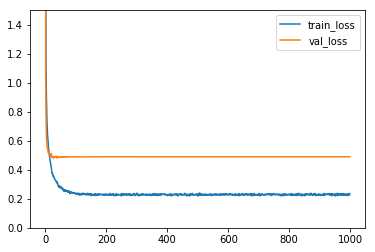

In [24]:
plt.plot(train_loss_list, label="train_loss")
plt.plot(val_loss_list, label="val_loss")
plt.legend()
plt.ylim([0,1.5])

In [26]:
out_softmax = nd.softmax(net(nd.array(X_test_resnet50_v1).as_in_context(ctx)))

synsets = mx.gluon.data.vision.ImageFolderDataset("/Users/shengwan/Desktop/data/train_gy").synsets
ids = sorted(os.listdir("/Users/shengwan/Desktop/data/test_gy/0/"))
ids = [i[:-4] for i in ids]

df = pd.DataFrame(out_softmax.asnumpy())
df.columns = synsets
df["id"] = ids
df = df[["id"]+synsets]
df.to_csv('/Users/shengwan/Desktop/data/pred-resnet50-v1.csv', index=None)